## Fashion AI: End-to-End Fashion Item Classification and Colour Extraction


In [3]:

import os                                                      # for path manipulations
import requests
# import gzip                                                  # handles the extraction of .gz files
import numpy as np                                             # for numerical operations like handling arrays
import matplotlib.pyplot as plt                                # useful for visualization
import random                                                  # for shuffling the list of images to split them randomly
import cv2                                                     # useful for manipulation
import shutil                                                  # Useful for high-level file operations (e.g., copying files or directories)
import glob                                                    # commonly used to list files in a directory

# from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
# from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont
import torch


from ultralytics import YOLO                                   # Importing YOLO object detection model from the Ultralytics package


# from segment_anything import sam_model_registry, SamPredictor
from sam2.build_sam import build_sam2                          #Function used to initialize and build the SAMv2 model from a configuration file and checkpoint.
from sam2.sam2_image_predictor import SAM2ImagePredictor       # SAM2ImagePredictor: A class used to make predictions with the SAMv2 model, specifically for image segmentation tasks.

from tqdm import tqdm                                          # for keep track of execution progress
import scipy                                                   # used for cientific and technical computing







base_path = '/home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering'


# This checkpoint file contains the pre-trained model parameters for SAMv2
checkpoint = os.path.join(base_path, "segment-anything-2/checkpoints/sam2_hiera_large.pt")


# The YAML file typically contains information on the model architecture and training configuration
model_cfg = "sam2_hiera_l.yaml"      # Define the configuration file for the SAMv2 model


# The mask_predictor object will be used to generate masks (segmentations) in future steps
mask_predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))





/home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/segment-anything-2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


### 1. Dataset Preparation

#### 1.1. Introduce Pathes to dataset and Visualize some Images

['JPEGImages/110094.jpg', 'JPEGImages/14487.jpg', 'JPEGImages/171333.jpg', 'JPEGImages/5083.jpg', 'JPEGImages/63693.jpg', 'JPEGImages/185734.jpg', 'JPEGImages/137557.jpg', 'JPEGImages/190401.jpg', 'JPEGImages/44699.jpg', 'JPEGImages/34330.jpg', 'JPEGImages/126558.jpg', 'JPEGImages/30742.jpg', 'JPEGImages/189281.jpg', 'JPEGImages/24740.jpg', 'JPEGImages/57175.jpg', 'JPEGImages/67317.jpg', 'JPEGImages/40836.jpg', 'JPEGImages/141529.jpg', 'JPEGImages/64292.jpg', 'JPEGImages/190668.jpg', 'JPEGImages/146188.jpg', 'JPEGImages/154108.jpg', 'JPEGImages/185518.jpg', 'JPEGImages/105848.jpg', 'JPEGImages/34066.jpg', 'JPEGImages/98409.jpg', 'JPEGImages/71912.jpg', 'JPEGImages/183082.jpg', 'JPEGImages/183067.jpg', 'JPEGImages/179874.jpg', 'JPEGImages/121499.jpg', 'JPEGImages/97381.jpg', 'JPEGImages/32633.jpg', 'JPEGImages/53715.jpg', 'JPEGImages/45131.jpg', 'JPEGImages/54661.jpg', 'JPEGImages/46727.jpg', 'JPEGImages/52946.jpg', 'JPEGImages/177810.jpg', 'JPEGImages/182800.jpg', 'JPEGImages/167287.jp

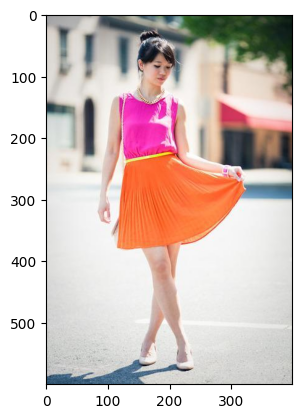

In [4]:

annotations_path = "Annotations"                                            # path to Annotations
list_of_xml_files = glob.glob(os.path.join(annotations_path, "*.xml"))      # create a list of xml file
# print(list_of_xml_files)


annotations_txt_path = "Annotations_txt"                                     # path to Annotations_txt
list_of_txt_files = glob.glob(os.path.join(annotations_txt_path, "*.txt"))   # list of Annotations_txt file


image_sets_path = "ImageSets/Main"                                           # path to ImageSets/Main
jpeg_images_path = "JPEGImages"                                              # path to JPEGImages
list_of_jpeg_images_path = glob.glob(os.path.join(jpeg_images_path, "*.jpg"))
print(list_of_jpeg_images_path)

# path to trainval and test files
trainval_files = os.path.join(image_sets_path, "trainval.txt")               # path to trainval.txt files
test_files= os.path.join(image_sets_path, "test.txt")                        # path to test.txt files


# read the trainval file
with open(trainval_files, 'r') as f:                                         
    trainval_images = f.readlines()
trainval_images = [line.strip() for line in trainval_images]

# read the test file
with open(test_files, 'r') as f:
    test_images = f.readlines()
test_images = [line.strip() for line in test_images]

print(f"trainval images list :{trainval_images}")
print(f"test images list:{test_images}")

#visualize images

trainval_images_path = [os.path.join(jpeg_images_path, f"{img_id}.jpg") for img_id in trainval_images]
test_images_path = [os.path.join(jpeg_images_path, f'{img_id}.jpg') for img_id in test_images]
image = Image.open(trainval_images_path[0]).convert('RGB')
plt.imshow(image)
plt.show()



#### Visualize more Images

['JPEGImages/127704.jpg', 'JPEGImages/70107.jpg', 'JPEGImages/155803.jpg', 'JPEGImages/4611.jpg', 'JPEGImages/37902.jpg', 'JPEGImages/191323.jpg']


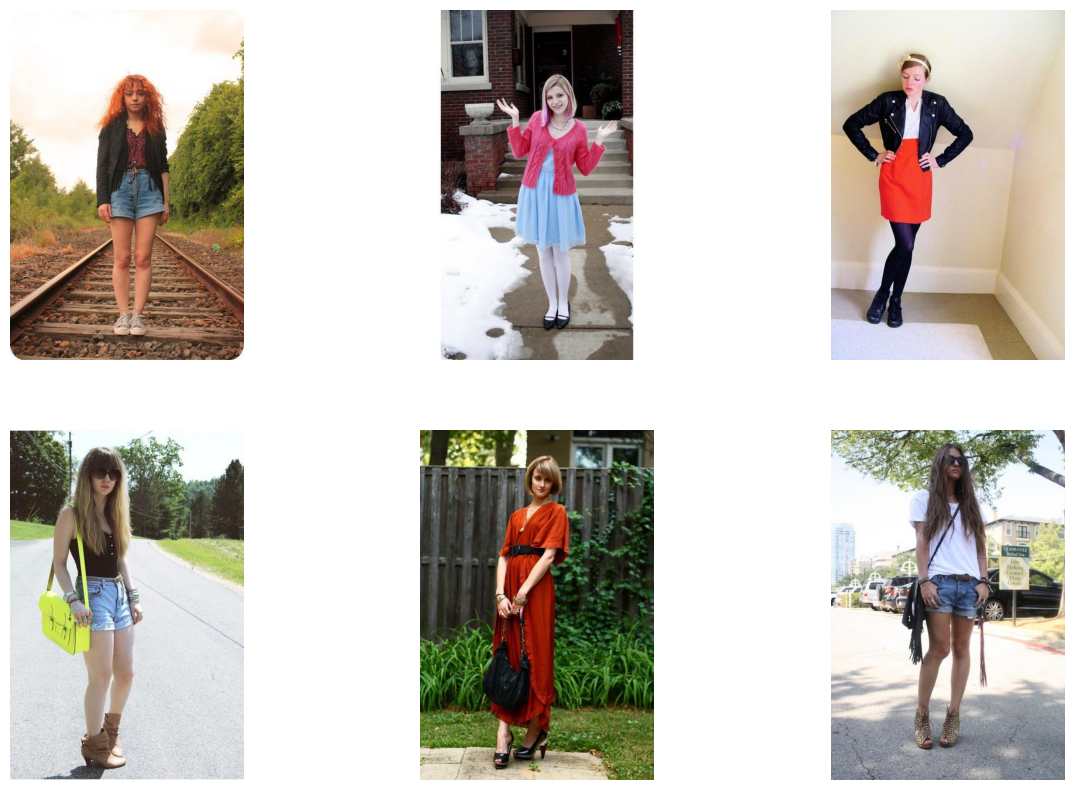

In [5]:
import PIL
import os

annotations_path = "Annotations"
list_of_xml_files = glob.glob(os.path.join(annotations_path, "*.xml"))


annotations_txt_path = "Annotations_txt"
list_of_txt_files = glob.glob(os.path.join(annotations_txt_path, "*.txt"))


image_sets_path = "ImageSets/Main"
jpeg_images_path = "JPEGImages"
list_of_jpeg_images_path = glob.glob(os.path.join(jpeg_images_path, "*.jpg"))

# function to visualize some images with their pathes
def visualize_images(list_of_jpeg_images_path):
    random_sample_images_path = random.sample(list_of_jpeg_images_path, 6)
    print(random_sample_images_path)
    fig, axes = plt.subplots(2, 3, figsize = (15, 10))
    axes = axes.ravel()
    for i in range(len(random_sample_images_path)):   
        image = Image.open(random_sample_images_path[i]).convert('RGB')
        axes[i].imshow(image)
        axes[i].axis('off')
    plt.show()
visualize_images(list_of_jpeg_images_path)
    
    

- the txt format of annotations are in this format:

- class_id   x_center   y_center   width   height

- class_id is the class of object

- x_center, y_center are the center of the bounding boxes  

- width, height are width and height of the image 


- for this image we want to get bounding boxes for each clothing item and then crop image based on the bboxes in ground truth

- we define a function to parse txt file to extract bounding box coordinates along with the class id.

- The typical YOLO .txt format has the following structure:


- Class_id center_x center_y width height
- Each line in the .txt file represents one bounding box.

- The values center_x, center_y, width, and height are normalized (between 0 and 1) relative to the image dimensions.
- we want to convert these format to pixel coordinates format like : x_min, y_min, x_max, y_max only for visualization  (overlay) of bounding box on the object. but when using YOLO for both fine tuning and inference we need the original txt format.


-we will need to load the image using a library like PIL or OpenCV.
- Reading the Bounding Boxes:


we Convert the normalized coordinates into pixel coordinates in order to overlay bounding boxes on image for exploring.



['3 0.426250 0.308333 0.257500 0.186667\n', '9 0.501250 0.930000 0.222500 0.060000\n', '6 0.547500 0.508333 0.520000 0.253333']
['3', '0.426250', '0.308333', '0.257500', '0.186667']
['9', '0.501250', '0.930000', '0.222500', '0.060000']
['6', '0.547500', '0.508333', '0.520000', '0.253333']
[(3, 119, 128, 222, 240), (9, 155, 540, 244, 576), (6, 114, 228, 323, 380)]


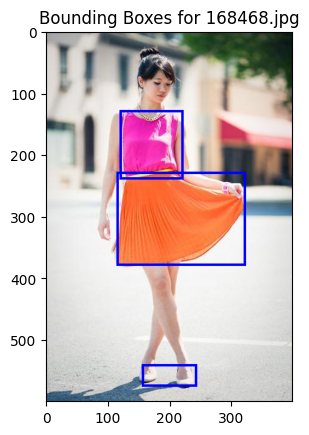

In [8]:
import os
from PIL import Image, ImageDraw
import glob
import matplotlib.pyplot as plt

# Define paths
annotations_txt_path = "Annotations_txt"
jpeg_images_path = "JPEGImages"

# Get lists of annotation files and images
list_of_txt_files = glob.glob(os.path.join(annotations_txt_path, "*.txt"))
list_of_jpeg_images_path = glob.glob(os.path.join(jpeg_images_path, "*.jpg"))


# Read the trainval file
image_sets_path = "ImageSets/Main"
trainval_files = os.path.join(image_sets_path, "trainval.txt")

with open(trainval_files, 'r') as f:
    trainval_images = f.readlines()
trainval_images = [line.strip() for line in trainval_images]

# Construct full paths to the images
trainval_images_path = [os.path.join(jpeg_images_path, f"{img_id}.jpg") for img_id in trainval_images]



# Function to read bounding boxes from a YOLO format text file
def read_bounding_box(txt_file):
    
    with open(txt_file, 'r') as f:     # function to load and read a file
        lines = f.readlines()         
        print(lines)
    boxes = []
    for line in lines:                # loop through each line
        parts = line.strip().split()  
        print(parts)
        class_id = int(parts[0])      # the first part is the class id
        center_x = float(parts[1])     # the second part is center_x
        center_y = float(parts[2])     # the third part is center_y
        width = float(parts[3])        # the forth part is bounding box width
        height = float(parts[4])       # the fifth part is bounding box height
        boxes.append([class_id, center_x, center_y, width, height])
        
    return boxes

# Function to convert YOLO bounding box coordinates to pixel coordinates
def convert_yolo_to_pixel(box, img_width, img_height):
    class_id, center_x, center_y, width, height = box
    x_min = int((center_x - width / 2) * img_width)
    y_min = int((center_y - height / 2) * img_height)
    x_max = int((center_x + width / 2) * img_width)
    y_max = int((center_y + height / 2) * img_height)
    return (class_id, x_min, y_min, x_max, y_max)

# Function to draw bounding boxes on an image
def draw_bounding_boxes(image_path, annotation_path):
    # Open the image and get its dimensions
    image = Image.open(image_path).convert('RGB')
    img_width, img_height = image.size

    # Read bounding boxes from the annotation file
    boxes = read_bounding_box(annotation_path)
    pixel_boxes = [convert_yolo_to_pixel(box, img_width, img_height) for box in boxes]
    print(pixel_boxes)
    
    # Draw bounding boxes on the image
    draw = ImageDraw.Draw(image)
    for pixel_box in pixel_boxes:
        class_id, x_min, y_min, x_max, y_max = pixel_box
        draw.rectangle([x_min, y_min, x_max, y_max], outline="blue", width=4)
    
    # Display the image with the bounding boxes
    plt.imshow(image)
    plt.title(f"Bounding Boxes for {os.path.basename(image_path)}")
    plt.show()

# Assuming the first image and first annotation file correspond
image_file = trainval_images_path[0]
annotation_file = os.path.join(annotations_txt_path, f"{trainval_images[0]}.txt")

# Draw bounding boxes on the selected image
draw_bounding_boxes(image_file, annotation_file)


#### 1.2. Preparing dataset for custom training and inference  with YOLOV8

- when applying YOLO, we need to have a particular format which is different with the original format of dataset. the dataset should have a format like this:


Colorful_Fashion_Dataset

    JPEGImages

        train
            img1.jpg
            img1.txt
            img2.jpg
            img2.txt
            ...
        
        val
            img3.jpg
            img3.txt
            ...


        test
            img4.jpg
            img4.txt
            ...

we can define a function organize images and their corresponding YOLO annotations into train / val / test directories under JPEGImages.

In [2]:
import os
import shutil
import glob
import random
from PIL import Image
import matplotlib.pyplot as plt

# Define paths based on our directory structure
annotations_path = "Annotations"
annotations_txt_path = "Annotations_txt"
image_sets_path = "ImageSets/Main"
jpeg_images_path = "JPEGImages"

# List XML, TXT, and JPEG files
list_of_xml_files = glob.glob(os.path.join(annotations_path, "*.xml"))
list_of_txt_files = glob.glob(os.path.join(annotations_txt_path, "*.txt"))
list_of_jpeg_images_path = glob.glob(os.path.join(jpeg_images_path, "*.jpg"))

# Paths to trainval.txt and test.txt
trainval_files = os.path.join(image_sets_path, "trainval.txt")
test_files = os.path.join(image_sets_path, "test.txt")

# Read the trainval and test files
with open(trainval_files, 'r') as f:
    trainval_images = f.readlines()
trainval_images = [line.strip() for line in trainval_images]
# print(len(trainval_images))

with open(test_files, 'r') as f:
    test_images = f.readlines()
test_images = [line.strip() for line in test_images]
print(len(test_images))

# Convert image IDs to full paths
trainval_images_path = [os.path.join(jpeg_images_path, f"{img_id}.jpg") for img_id in trainval_images]
test_images_path = [os.path.join(jpeg_images_path, f'{img_id}.jpg') for img_id in test_images]

# Now we want to split trainval images into two separate folders: train and val with 80/20 split.
random.shuffle(trainval_images)
split_idx = int(0.8 * len(trainval_images))

train_images = trainval_images[0:split_idx]
print(len(train_images))

val_images = trainval_images[split_idx:]
print(len(val_images))

# function to organize the dataset into YOLO format

def organize_file_to_yolo_format(image_list, subset):
    
    # Create subdirectory for images and annotations within the subset directory
    sub_dir = os.path.join(jpeg_images_path, subset)
    os.makedirs(sub_dir, exist_ok=True)
    
    for image_id in image_list:
        image_file = f"{image_id}.jpg"
        annot_file = f"{image_id}.txt"
        
        src_image = os.path.join(jpeg_images_path, image_file)          # Path to the image file in the current images directory

        dst_image = os.path.join(sub_dir, image_file)                   # Path to the image file in the destination directory (sub_dir)

        
        src_annotation = os.path.join(annotations_txt_path, annot_file) # Path to the current annotation file in the annotations directory

        dst_annotation = os.path.join(sub_dir, annot_file)              # Path to the annotations file in the destination directory (sub_dir)
 
        
        if os.path.exists(src_image) and os.path.exists(src_annotation):
            shutil.copy(src_image, dst_image)                           # Copy the source image to the destination directory

            shutil.copy(src_annotation, dst_annotation)                 # Copy the source annotation file to the destination directory

# Organize files for train, val, and test sets
organize_file_to_yolo_format(train_images, 'train')
organize_file_to_yolo_format(val_images, 'val')
organize_file_to_yolo_format(test_images, 'test')

print("Dataset organized successfully!")

537
1716
429
Dataset organized successfully!


#### 1.3. Create Yaml File

when using YOLOV8, a YAML file typically contains configuration information for the dataset, model parameters, and training settings. Here's a common structure 

for a YOLO dataset configuration YAML file

In [8]:
import torch
import ultralytics
import os

print(f"Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(device)

print(os.path.exists('obj_detect.yaml'))   # to check if yaml file exists or not

Using torch 2.4.0+cu121 (NVIDIA GeForce GTX 1080 Ti)
cuda
True


In [26]:
import os
import torch

#Define paths based on our directory structure

annotations_path = "Annotations"
annotations_txt_path = "Annotations_txt"
image_sets_path = "ImageSets/Main"
jpeg_images_path = "JPEGImages"
train_image_path = os.path.join(jpeg_images_path, "train")
val_image_path = os.path.join(jpeg_images_path, "val")
test_image_path = os.path.join(jpeg_images_path, "test")


yaml_path = 'obj_detect.yaml'  # to check yaml file exists
if os.path.exists(yaml_path):
    print("YAML file exists!")
else:
    print("YAML file does not exist!")
print(yaml_path)


YAML file exists!
obj_detect.yaml


when using frameworks like YOLO we need some directories and subdirectories for organizing the results

1- runs/detect:

This directory structure is used to organize and store the results of different training runs. Each time we train a model, we might want to save the model's weights, logs, evaluation metrics, and sample predictions for later analysis or comparison with other runs

2- train:

This subdirectory specifically stores the results related to a training run. Each training session might generate new data, and keeping this organized helps in managing different experiments

3- weights:

Within the train directory, the weights subdirectory stores the model's weights after training. These weights are essential if you want to later load the model for inference or further training

### 2. Fine-tune YOLOV8 on Colorful Fashion Dataset

In [9]:
import os
import torch
from ultralytics import YOLO

device = 'cuda' if torch.cuda.is_available() else 'cpu'

base_path = '/home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering'

#define  path for runs and detect
runs_path = os.path.join(base_path, 'runs', 'detect')
weights_save_path = os.path.join(runs_path, 'train', 'weights')
# Ensure the runs/detect directory exists
os.makedirs(runs_path, exist_ok = True)
# Ensure the weights save directory exists




# Define the path to your dataset and model
model_path = 'yolov8l.pt'



yaml_path =  os.path.join(base_path, "obj_detect.yaml")


# fine tune yolov8 on our colorful fashion dataset
model = YOLO("yolov8l.pt")
model.train(data= yaml_path, epochs=30, imgsz=640, device = device, project = runs_path, save_period = -1, save = True)  # train the model on 30 epochs with image size 640 * 640


New https://pypi.org/project/ultralytics/8.2.101 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.78 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11162MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/obj_detect.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=/home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/runs/detect, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_st

train: Scanning /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/JPEGImages/train... 1716 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1716/1716 [00:00<00:00, 1797.87it/s]

train: New cache created: /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/JPEGImages/train.cache



val: Scanning /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/JPEGImages/val... 429 images, 0 backgrounds, 0 corrupt: 100%|██████████| 429/429 [00:00<00:00, 765.42it/s]

val: New cache created: /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/JPEGImages/val.cache


Plotting labels to /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/runs/detect/train6
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      10.8G      1.315      1.827      1.488         33        640: 100%|██████████| 108/108 [04:18<00:00,  2.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:16<00:00,  1.20s/it]

                   all        429       1665      0.574      0.537      0.547      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      11.1G      1.309      1.368      1.485         37        640: 100%|██████████| 108/108 [05:19<00:00,  2.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:18<00:00,  1.30s/it]

                   all        429       1665       0.56      0.578      0.582       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      11.1G      1.332      1.324      1.519         37        640: 100%|██████████| 108/108 [05:43<00:00,  3.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:19<00:00,  1.39s/it]

                   all        429       1665      0.636      0.559      0.589       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      11.1G      1.334      1.263      1.531         33        640: 100%|██████████| 108/108 [05:58<00:00,  3.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:19<00:00,  1.39s/it]

                   all        429       1665       0.57       0.65      0.641      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      10.8G      1.286        1.2      1.493         23        640: 100%|██████████| 108/108 [06:04<00:00,  3.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:20<00:00,  1.46s/it]

                   all        429       1665      0.624      0.656      0.656      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      10.2G      1.273      1.165      1.485         33        640: 100%|██████████| 108/108 [06:06<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:19<00:00,  1.43s/it]

                   all        429       1665      0.636      0.686      0.687      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      11.1G      1.218      1.101      1.446         32        640: 100%|██████████| 108/108 [06:11<00:00,  3.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:20<00:00,  1.47s/it]

                   all        429       1665      0.743      0.672      0.711      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      10.8G      1.211      1.051      1.436         54        640: 100%|██████████| 108/108 [06:14<00:00,  3.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:21<00:00,  1.50s/it]

                   all        429       1665      0.742      0.688      0.721      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      10.8G      1.189      1.028      1.431         27        640: 100%|██████████| 108/108 [06:13<00:00,  3.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:21<00:00,  1.52s/it]

                   all        429       1665      0.651      0.728      0.728      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      10.8G       1.17     0.9824      1.417         39        640: 100%|██████████| 108/108 [06:18<00:00,  3.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:19<00:00,  1.41s/it]

                   all        429       1665      0.724       0.72      0.752      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      11.1G      1.154     0.9501      1.399         29        640: 100%|██████████| 108/108 [06:16<00:00,  3.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:21<00:00,  1.53s/it]

                   all        429       1665      0.748      0.721      0.749       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      11.1G      1.116     0.9032      1.374         29        640: 100%|██████████| 108/108 [06:16<00:00,  3.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:20<00:00,  1.49s/it]

                   all        429       1665      0.682      0.748      0.748      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      11.1G      1.106     0.8762       1.37         39        640: 100%|██████████| 108/108 [06:15<00:00,  3.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:21<00:00,  1.53s/it]

                   all        429       1665        0.7       0.77      0.767      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      11.1G      1.084     0.8605       1.36         35        640: 100%|██████████| 108/108 [06:15<00:00,  3.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]

                   all        429       1665      0.737       0.72      0.763      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      11.1G      1.067     0.8227      1.342         18        640: 100%|██████████| 108/108 [06:15<00:00,  3.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:21<00:00,  1.50s/it]

                   all        429       1665      0.695      0.764       0.77      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      11.1G      1.055      0.808      1.338         18        640: 100%|██████████| 108/108 [06:18<00:00,  3.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:21<00:00,  1.56s/it]

                   all        429       1665      0.734      0.729      0.762      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      11.1G      1.043     0.7888       1.32         26        640: 100%|██████████| 108/108 [06:17<00:00,  3.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:21<00:00,  1.53s/it]

                   all        429       1665      0.711      0.775      0.774       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      11.1G      1.022     0.7442      1.299         23        640: 100%|██████████| 108/108 [06:16<00:00,  3.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:22<00:00,  1.57s/it]

                   all        429       1665      0.766      0.712      0.771      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      11.1G      1.005     0.7335      1.298         26        640: 100%|██████████| 108/108 [06:16<00:00,  3.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:21<00:00,  1.57s/it]

                   all        429       1665      0.707      0.767      0.772      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      11.1G     0.9841     0.7209       1.29         21        640: 100%|██████████| 108/108 [06:18<00:00,  3.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:20<00:00,  1.45s/it]

                   all        429       1665      0.755       0.76      0.785      0.532


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      11.1G     0.9542     0.6504      1.307         13        640: 100%|██████████| 108/108 [06:16<00:00,  3.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:20<00:00,  1.50s/it]

                   all        429       1665      0.752      0.762      0.783      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      11.1G      0.922     0.6185      1.286         15        640: 100%|██████████| 108/108 [06:13<00:00,  3.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:21<00:00,  1.55s/it]

                   all        429       1665      0.724      0.749       0.77       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      11.1G     0.9011     0.5914      1.273         14        640: 100%|██████████| 108/108 [06:13<00:00,  3.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]

                   all        429       1665      0.751      0.755      0.787      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      10.8G     0.8836     0.5748      1.265         15        640: 100%|██████████| 108/108 [06:15<00:00,  3.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]

                   all        429       1665      0.745       0.76      0.783      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      11.1G     0.8701     0.5521      1.241         14        640: 100%|██████████| 108/108 [06:17<00:00,  3.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:20<00:00,  1.49s/it]

                   all        429       1665      0.755      0.769      0.785      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      11.1G     0.8539     0.5255      1.235         17        640: 100%|██████████| 108/108 [06:16<00:00,  3.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:20<00:00,  1.49s/it]

                   all        429       1665      0.739      0.773      0.787      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      11.1G     0.8251     0.5025       1.22         16        640: 100%|██████████| 108/108 [06:16<00:00,  3.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:21<00:00,  1.56s/it]

                   all        429       1665      0.724      0.766      0.783      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      11.1G     0.8041      0.477      1.191         14        640: 100%|██████████| 108/108 [06:15<00:00,  3.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:21<00:00,  1.52s/it]

                   all        429       1665      0.729      0.765      0.783      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      11.1G     0.7949     0.4648      1.194         15        640: 100%|██████████| 108/108 [06:15<00:00,  3.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:21<00:00,  1.55s/it]

                   all        429       1665      0.758      0.754      0.785      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      10.8G     0.7705     0.4433      1.169         14        640: 100%|██████████| 108/108 [06:16<00:00,  3.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]

                   all        429       1665      0.767      0.755      0.784      0.547



30 epochs completed in 3.258 hours.
Optimizer stripped from /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/runs/detect/train6/weights/last.pt, 87.6MB
Optimizer stripped from /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/runs/detect/train6/weights/best.pt, 87.6MB

Validating /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/runs/detect/train6/weights/best.pt...
Ultralytics YOLOv8.2.78 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11162MiB)
Model summary (fused): 268 layers, 43,614,318 parameters, 0 gradients, 164.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:20<00:00,  1.45s/it]


                   all        429       1665      0.758      0.754      0.784      0.548
              sunglass         69         69      0.449      0.217      0.356      0.129
                   hat         52         52      0.675      0.692      0.737      0.412
                jacket        158        162       0.76      0.883      0.843      0.673
                 shirt        290        299      0.814      0.807      0.859      0.598
                 pants        102        102       0.92      0.912      0.925      0.753
                shorts         74         74      0.825      0.765      0.781      0.524
                 skirt        148        148      0.811      0.899      0.894      0.693
                 dress        107        107      0.775      0.879      0.872      0.743
                   bag        235        235      0.756      0.706      0.773      0.475
                  shoe        417        417      0.797      0.779      0.803      0.478
Speed: 0.2ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c56e43fecb0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0